---
title: Pseudospectral Differences (QG)
---

In [1]:
# !pip install git+https://github.com/jejjohnson/jaxsw@eman

In [2]:
# import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.base_v2 import Domain, init_domain_1d
import math
# from jaxsw._src.fields.base import Field
import jax.random as jrandom
from jaxsw import Field, FDField, SpectralField
from jaxsw._src.operators.functional import finitediff as F_fd
from jaxsw._src.operators.functional import spectral as F_spectral

jax.config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

### Problem Background

$$
\partial_t q + u \partial_x q + v \partial_y q = \nu \Delta q
$$

where
* $q=\Delta\psi$ - relative vorticity
* $u=-\partial_u\psi$ - zonal velocity
* $v=\partial_x\psi$ - meridonal velocity

### Domain

In [23]:
Nx, Ny = 256, 256
Lx, Ly = 3.0*math.pi, 3.0*math.pi
dx, dy = Lx/Nx, Ly/Ny

x_domain = Domain(xmin=0, xmax=Lx-dx, dx=dx, Nx=Nx, Lx=Lx)
y_domain = Domain(xmin=0, xmax=Ly-dy, dx=dy, Nx=Ny, Lx=Ly)

xy_domain = x_domain * y_domain

In [24]:
# construct parameters
key = jrandom.PRNGKey(123)
u0: Array = jrandom.normal(key=key, shape=xy_domain.Nx)
u: Field = SpectralField(values=u0, domain=xy_domain)

In [25]:
u.k_vec[0].shape, u.k_vec[1].shape

((256,), (256,))

In [26]:
import einops
import functools
import typing as tp

* kvec vs K
* aliasing - where
* real vs complex
* scaling...

* u [Nx]
* kvec [Nfx]
* aliasing kvec [Nfx]
* apply fft transform [Nx] --> [Nfx]
* difference: kvec * uf [Nfx]x[Nfx]
* inverse fft [Nfx] --> [Nx]

---

**Tests**

* simple functions - exponential, cosine
* 1D, 2D, 3D
* real consistency
* shapes - real
* types - real
* check operator shapes - K, L, etc


**Examples**

* 1D Example
* 2D Example
* Mixed! Periodic + Mixed (Spectral + FiniteDifference)
* Spherical Harmonics - 2D Periodic (lat,lon) + 1D FD (radial)
* Faster
    * separate the nonlinear and linear
    * solver - implicit (linear, division!), explicit (nonlinear) 
    * stability conditional on viscosity - stepsize larger

**Fields**

```python
u: Field = ... [Nx,Ny]
v: Field = ... [cNx, cNy]

# transform to domain
u_on_v_domain = Transformation(...)

# 

```

$$
|k|^{2n}
$$

In [28]:
# jnp.fft.rfftfreq??

In [46]:
def calculate_fft_freq(Nx: int, Lx: float = 2.0 * math.pi) -> Array:
    """a helper function to generate 1D FFT frequencies

    Args:
        Nx (int): the number of points for the grid
        Lx (float): the distance for the points along the grid

    Returns:
        freq (Array): the 1D fourier frequencies
    """
    # return jnp.fft.fftfreq(n=Nx, d=Lx / (2.0 * math.pi * Nx))
    return (2 * math.pi / Lx) * jnp.fft.rfftfreq(n=Nx, d=Lx / (Nx * 2.0 * math.pi))

def fft_transform(u: Array, axis: int = -1, inverse: bool = False) -> Array:
    """the FFT transformation (forward and inverse)

    Args:
        u (Array): the input array to be transformed
        axis (int, optional): the axis to do the FFT transformation. Defaults to -1.
        scale (float, optional): the scaler value to rescale the inputs.
            Defaults to 1.0.
        inverse (bool, optional): whether to do the forward or inverse transformation.
            Defaults to False.

    Returns:
        u (Array): the transformation that maybe forward or backwards
    """
    # check if complex or real (save time!!!)
    if inverse:
        return jnp.fft.irfft(a=u, axis=axis)
    else:
        return jnp.fft.rfft(a=u, axis=axis)
    
    
def spectral_difference(
    fu: Array, k_vec: Array, axis: int = 0, derivative: int = 1
) -> Array:
    """the difference method in spectral space

    Args:
        fu (Array): the array in spectral space to take the difference
        k_vec (Array): the parameters to take the finite difference
        axis (int, optional): the axis of the multidim array, u, to
            take the finite difference. Defaults to 0.
        derivative (int, optional): the number of derivatives to take.
            Defaults to 1.

    Returns:
        dfu (Array): the finite difference method
    """

    # reshape axis
    fu = jnp.moveaxis(fu, axis, -1)

    # do difference method
    dfu = fu * (1j * k_vec) ** float(derivative)

    # re-reshape axis
    dfu = jnp.moveaxis(dfu, -1, axis)

    return dfu

In [40]:
# from spectraldiffx._src.operators import elliptical_operator
# from spectraldiffx._src.utils import calculate_aliasing, calculate_fft_freq

In [51]:
# calculate vector
k_vec = [calculate_fft_freq(Nx,Lx) for Nx, Lx in zip(xy_domain.Nx, xy_domain.Lx)]

# calculate FFT transformation
fux = fft_transform(u[:], axis=-2, inverse=False)

# do derivative
dfudx = spectral_difference(fux, k_vec[-2], derivative=1)

# calculate inverse FFT transformation
dudx = fft_transform(dfudx, axis=-2, inverse=True)

dudx

Array([[ 26.94409556, -27.39627296, -37.9810061 , ..., -42.37195334,
         15.83244466,   0.25307312],
       [-19.4946798 ,  35.63317398,  27.89729145, ...,  16.06985123,
        -26.33658714, -12.04052366],
       [ -4.80559839, -58.42318075,  18.74974589, ..., -14.72473859,
         46.75021416,  60.3414944 ],
       ...,
       [ -9.68031822,   4.79235106,  15.70550905, ..., -10.1315801 ,
          7.40272814, -23.21597535],
       [ 40.23732287,  44.01932978, -14.26657007, ...,  13.40768944,
         -6.85449898,  21.3698672 ],
       [-40.84661582,  -9.88282667,  18.14300844, ...,  35.69979378,
          2.61846661, -28.04167992]], dtype=float64)

In [21]:
u_ = jnp.fft.rfft(a=u[:], axis=-1)
u_.shape

(256, 129)

In [17]:
k_vec[0].shape, k_vec[1].shape

((129,), (129,))

In [8]:
ksq = elliptical_operator(u.k_vec)

In [9]:
# generate aliasing condition
cond = [calculate_aliasing(ikvec) for ikvec in u.k_vec]

assert cond[0].shape == u.k_vec[0].shape
assert cond[1].shape == u.k_vec[1].shape

In [11]:

# create operators
K = einops.repeat(u.k_vec[0], "Nx -> Nx Ny", Ny=Ny)
L = einops.repeat(u.k_vec[1], "Ny -> Nx Ny", Nx=Nx)

# create aliased operators
K_aliased = einops.repeat(u.k_vec[0], "Nx -> Nx Ny", Ny=Ny)
L_aliased = einops.repeat(u.k_vec[1], "Ny -> Nx Ny", Nx=Nx)

In [26]:
K, K_aliased

(Array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        ...,
        [-3., -3., -3., ..., -3., -3., -3.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-1., -1., -1., ..., -1., -1., -1.]], dtype=float64),
 Array([[ 86.,  86.,  86., ...,  86.,  86.,  86.],
        [ 87.,  87.,  87., ...,  87.,  87.,  87.],
        [ 88.,  88.,  88., ...,  88.,  88.,  88.],
        ...,
        [-88., -88., -88., ..., -88., -88., -88.],
        [-87., -87., -87., ..., -87., -87., -87.],
        [-86., -86., -86., ..., -86., -86., -86.]], dtype=float64))

In [33]:



# create dealiasing mask (for 2/3 rule)
def aliased(waves, ratio: float = 1.0/3.0) -> jax.Array:
    cond = functools.reduce(jnp.logical_or, [jnp.abs(w_i) > (1 - ratio) * jnp.abs(w_i).max() for w_i in waves])
    return cond

k_mask = aliased([K,L])

# create inversion array
invksq = 1.0 / ksq
invksq = invksq.at[0,0].set(1.0)

In [ ]:
k_mask.shape

In [ ]:
# potential vorticity
def generate_q0(domain, seed: int=42):
    rng = np.random.RandomState(seed)
    q0 = rng.randn(*domain.Nx)
    qh0 = np.fft.fftn(q0)
    qh0 = SpectralField(values=qh0, domain=domain)
    ksq = F_spectral.elliptical_operator_2D(qh0.k_vec)
    qh0 = qh0[:]
    qh0 = np.where(ksq > 10**2, 0.0, qh0)
    qh0 = np.where(ksq < 3**2, 0.0, qh0)
    q0 = np.real(np.fft.ifftn(qh0))
    return jnp.asarray(qh0), jnp.asarray(q0)

qh0, q0 = generate_q0(xy_domain, 42)
K = K.astype(qh0.dtype)
L = L.astype(qh0.dtype)
invksq = invksq.astype(qh0.dtype)
ksq = ksq.astype(qh0.dtype)
# stream function
psih0 = - invksq * qh0
psi0 = jnp.real(jnp.fft.ifftn(psih0))

# velocities
u0 = jnp.real(jnp.fft.ifftn(-1j * L * psih0))
v0 = jnp.real(jnp.fft.ifftn(1j * K * psih0))

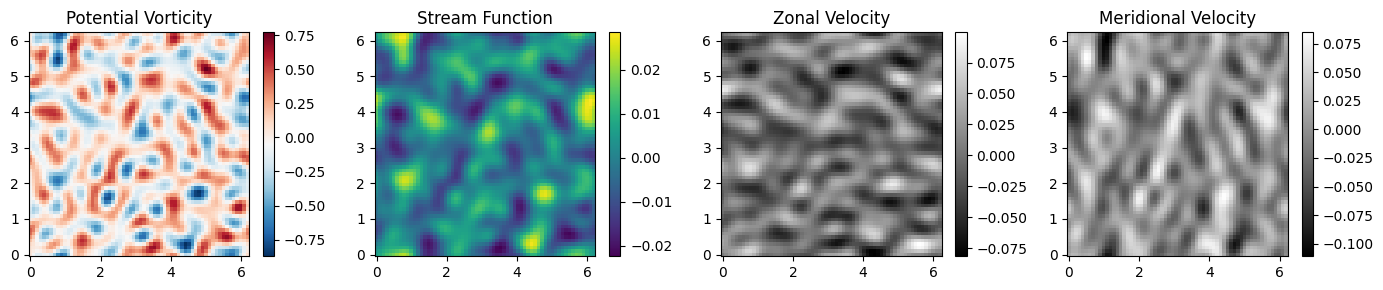

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(14,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0, cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi0)
ax[1].set(title="Stream Function")
plt.colorbar(pts)

pts = ax[2].pcolormesh(X, Y, u0, cmap="gray")
ax[2].set(title="Zonal Velocity")
plt.colorbar(pts)

pts = ax[3].pcolormesh(X, Y, v0, cmap="gray")
ax[3].set(title="Meridional Velocity")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
def equation_of_motion(qh: Array, nu: float) -> Array:

    # calculate psi
    psih = - invksq * qh

    # calculate velocities
    u = jnp.real(jnp.fft.ifftn(- 1j * L * psih))
    v = jnp.real(jnp.fft.ifftn(1j * K * psih))
    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = jnp.real(jnp.fft.ifftn(1j * K * qh))
    dqh_dy = jnp.real(jnp.fft.ifftn(1j * L * qh))

    adv_rhs = - jnp.fft.fftn(u*dqh_dx + v*dqh_dy)



    # calculate diffusion term
    diff_rhs = - nu * ksq * qh


    return adv_rhs + diff_rhs

def plot_field(u, name: str=""):

    fig, ax = plt.subplots(figsize=(4,3))

    pts = ax.pcolormesh(X, Y, np.real(u), cmap="RdBu_r")
    plt.colorbar(pts)
    ax.set(title=name)

    plt.tight_layout()
    plt.show()

complex128 complex128


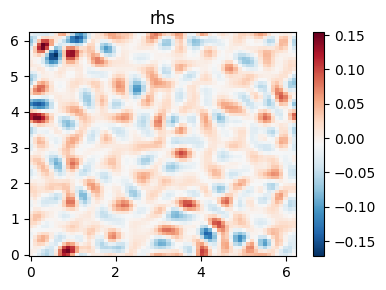

In [ ]:
nu = 3.0e-04
rhs = equation_of_motion(qh0, nu)
print((rhs).dtype, (qh0).dtype)

plot_field(jnp.fft.ifftn(rhs), name="rhs")

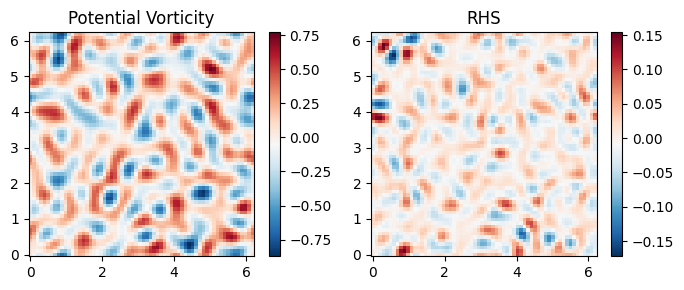

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh0)), cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(rhs)), cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
nu=3.0e-04

dt = 0.025
t1 = 1_000
num_steps = int(t1/dt)

ts = jnp.arange(0, t1, dt)

In [ ]:
from tqdm.autonotebook import tqdm

qh0, q = generate_q0(xy_domain, 42)

qh = jnp.copy(qh0)

fn = jax.jit(equation_of_motion, static_argnames="nu")

for i in tqdm(ts):

    rhs = fn(qh, nu)

    qh = qh + dt*rhs




<ipython-input-14-a0c3e3a83134>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/40000 [00:00<?, ?it/s]

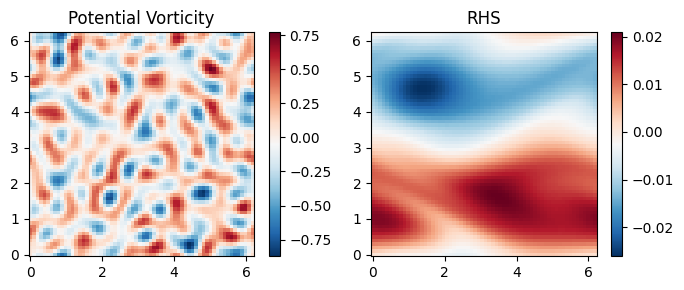

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh0)), cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh)), cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
# stream function
psih = - invksq * qh
psi = jnp.real(jnp.fft.ifftn(psih))

# velocities
u = jnp.real(jnp.fft.ifftn(-1j * L * psih))
v = jnp.real(jnp.fft.ifftn(1j * K * psih))

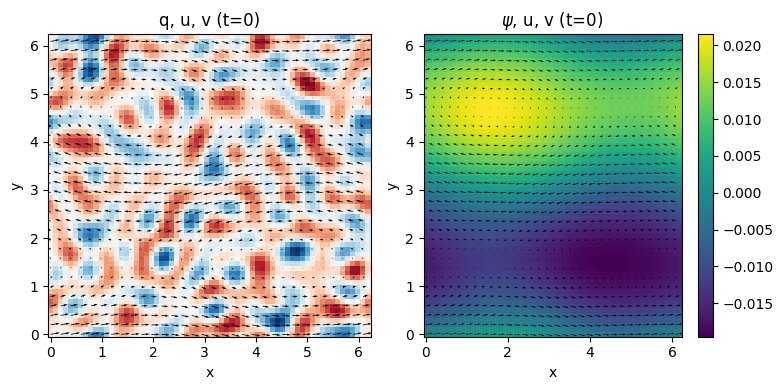

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

nc = int(Nx/32)

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q[:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title="q, u, v (t=0)")

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title="$\psi$, u, v (t=0)")


plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Diffrax Integration Scheme

In [ ]:
def equation_of_motion_real(q: Array, nu: float) -> Array:

    qh = jnp.fft.fftn(q)

    # calculate psi
    psih = - invksq * qh

    # calculate velocities
    u = jnp.real(jnp.fft.ifftn(- 1j * L * psih))
    v = jnp.real(jnp.fft.ifftn(1j * K * psih))
    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = jnp.real(jnp.fft.ifftn(1j * K * qh))
    dqh_dy = jnp.real(jnp.fft.ifftn(1j * L * qh))

    adv_rhs = - jnp.fft.fftn(u*dqh_dx + v*dqh_dy)

    # calculate diffusion term
    diff_rhs = - nu * ksq * qh

    rhs = adv_rhs + diff_rhs

    rhs = jnp.real(jnp.fft.ifftn(rhs))

    return rhs

In [ ]:
import diffrax as dfx

/usr/local/lib/python3.10/dist-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [ ]:
# Euler, Constant StepSize
# solver = dfx.Euler()
# stepsize_controller = dfx.ConstantStepSize()

solver = dfx.Dopri5()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)

In [ ]:
t0, t1 = 0.0, 1_000.0 #1_000.0
t_save = np.linspace(t0, t1, 100)
saveat = dfx.SaveAt(ts=t_save)

In [ ]:
class State(tp.NamedTuple):
    q: Array

def vector_field(t, state: State, args) -> State:
    nu = args
    q = state.q
    rhs = equation_of_motion_real(q=q, nu=nu)
    return State(q=rhs)

In [ ]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=State(q=q0),
    saveat=saveat,
    args=nu,
    stepsize_controller=stepsize_controller,
    # max_steps=
)

In [ ]:
# sol.ys

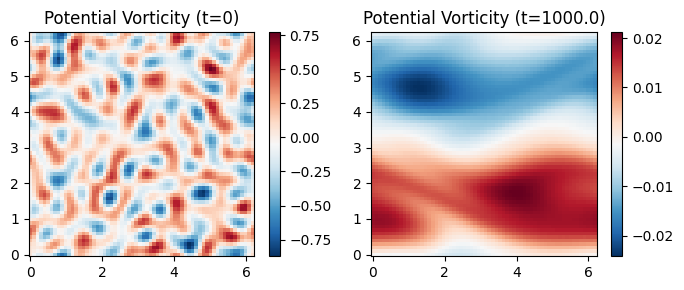

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis
q = sol.ys.q[-1]


pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity (t=0)")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, q[:], cmap="RdBu_r")
ax[1].set(title=f"Potential Vorticity (t={t1})")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
q = SpectralField(q, xy_domain)
psi = F_spectral.elliptical_inversion_2D(q)
u = - F_spectral.difference_field(psi, axis=1, derivative=1, real=True)
v = F_spectral.difference_field(psi, axis=0, derivative=1, real=True)

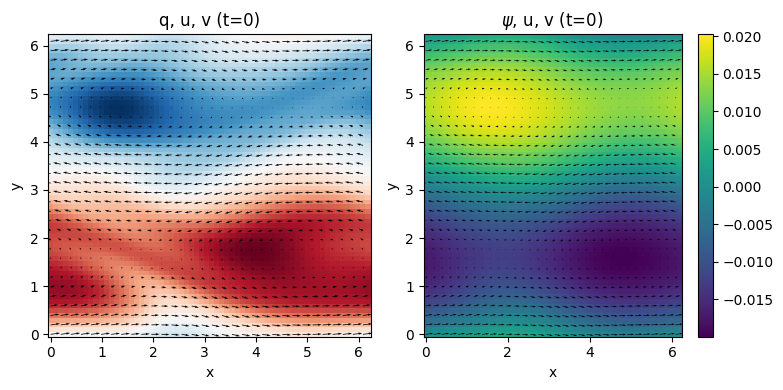

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

nc = int(Nx/32)

X, Y = q.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q[:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title="q, u, v (t=0)")

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title="$\psi$, u, v (t=0)")


plt.colorbar(pts)

plt.tight_layout()
plt.show()

### REFACTORED

In [ ]:
Nx, Ny = 64, 64
Lx, Ly = 2.0*math.pi, 2.0*math.pi
dx, dy = Lx/Nx, Ly/Ny

x_domain = Domain(xmin=0, xmax=Lx-dx, dx=dx, Nx=Nx, Lx=Lx)
y_domain = Domain(xmin=0, xmax=Ly-dy, dx=dy, Nx=Ny, Lx=Ly)

xy_domain = x_domain * y_domain

In [ ]:
qh0, q0 = generate_q0(xy_domain, 42)

In [ ]:
class Params(eqx.Module):
    nu: float = eqx.static_field() # viscosity coefficient
    mu: float = eqx.static_field() # linear drag
    beta: float = eqx.static_field() # Planetary vorticity y-gradient
    nv: int = eqx.static_field() # hyperviscous order

l_unit = 5_040e3 / math.pi
t_unit = 1.2e6

params = Params(
    nu=3.0e-04, # 352 / l_unit**2 / t_unit
    mu=0.0, #1.24e-8 / t_unit**(-1),
    beta=0.0, #0.5,
    nv=1, # hyperviscous order
)
params

Params(nu=0.0003, mu=0.0, beta=0.0, nv=1)

In [ ]:
from jaxsw._src.operators.constant import Constant

def equation_of_motion_field(q: Field, params: Params) -> Array:

    # ==============================
    # calculate psi (Elliptical inversion)
    # ----------------
    # q = ∇²ψ
    # q̂ = (|k|² + 1/ℓ²)ψ̂
    # ψ̂ = q / (|k|² + 1/ℓ²)
    # ==============================
    psi = F_spectral.elliptical_inversion_2D(q)

    # ###############################
    # Advection Term
    # ----------------
    # ∇⋅(uq) = u ∂x q + v ∂y q
    #        = u ikx q̂ + iky q̂
    # where
    #  u = - ∂yψ = - iky ψ̂
    #  v =   ∂xψ =   ikx ψ̂
    # ###############################

    # calculate velocities
    u = - F_spectral.difference_field(psi, axis=1)
    v = F_spectral.difference_field(psi, axis=0)

    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = F_spectral.difference_field(q, axis=0)
    dqh_dy = F_spectral.difference_field(q, axis=1)

    rhs = - (u * dqh_dx + v * dqh_dy)

    # ###############################
    # Linear Terms
    # ###############################

    # ==============================
    # bottom drag
    # -----------
    # − μ q
    # ==============================
    if params.mu > 0.0:
        rhs += - Constant(params.mu) * q

    # ===================================
    # (hyper-) viscosity term
    # -----------------------
    # - ν|k|²ⁿ q
    # ===================================
    if params.nu > 0.0:
        rhs += - Constant(params.nu) * F_spectral.laplacian_field(q, order=params.nv)
    # ===================================
    # beta plane term
    # ---------------
    # - ∂xψ = - iβkx ψ̂
    #       = - β (ikx ψ̂)
    #       = - β v
    # =======================================
    if params.beta > 0.0:
        rhs += - Constant(params.beta) * v

    return rhs

In [ ]:
# # Euler, Constant StepSize
# solver = dfx.Euler()
# stepsize_controller = dfx.ConstantStepSize()

solver = dfx.Tsit5()
stepsize_controller = dfx.PIDController(rtol=1e-4, atol=1e-4)

In [ ]:
t0, t1 = 0.0, 1_000.0 #1_000.0
t_save = np.linspace(t0, t1, 100)
saveat = dfx.SaveAt(ts=t_save)

In [ ]:
class State(tp.NamedTuple):
    q: Field

def vector_field(t, state: State, args) -> State:
    params = args
    q = state.q
    rhs = equation_of_motion_field(q=q, params=params)
    return State(q=rhs)


In [ ]:
%%time

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=State(q=SpectralField(q0, xy_domain)),
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
    max_steps=6_000
)

CPU times: user 5.3 s, sys: 89.1 ms, total: 5.39 s
Wall time: 5.23 s


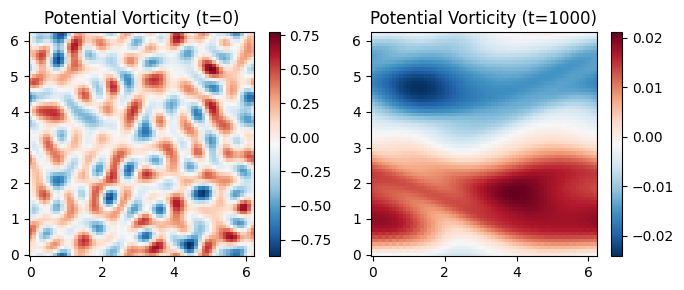

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis
q_plot = sol.ys.q[-1]


pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity (t=0)")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, q_plot[:], cmap="RdBu_r")
ax[1].set(title=f"Potential Vorticity (t={t1})")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
# q = SpectralField(q, xy_domain)
psi = F_spectral.elliptical_inversion_2D(SpectralField(sol.ys.q[-1], xy_domain))
u = - F_spectral.difference_field(psi, axis=1, derivative=1, real=True)
v = F_spectral.difference_field(psi, axis=0, derivative=1, real=True)

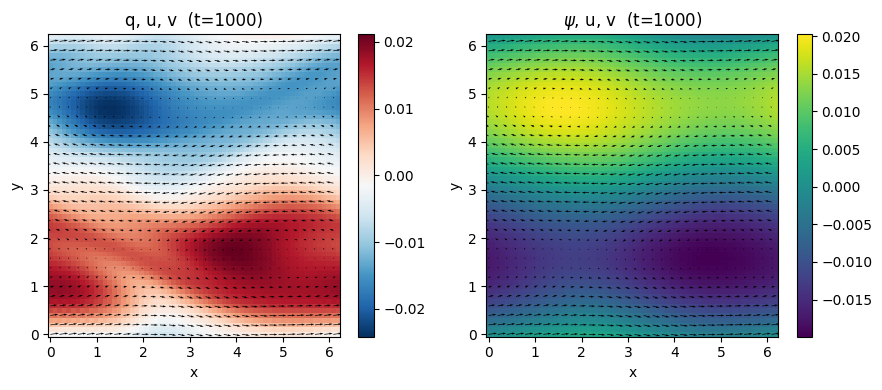

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

nc = int(Nx/32)

X, Y = sol.ys.q.domain.grid_axis
# q_plot = sol.ys.q[-2]

pts = ax[0].pcolormesh(X, Y, sol.ys.q[-1][:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title=f"q, u, v  (t={t1})")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title=f"$\psi$, u, v  (t={t1})")

plt.colorbar(pts)

plt.tight_layout()
plt.show()

# J. C. Mcwilliams (1984)

In [ ]:
# generate McWilliams 1984 initial condition
dl = 2.*math.pi/Ly
dk = 2.*math.pi/Lx
nl = Ny
nk = int(Nx/2+1)

ll = dl*np.append( np.arange(0.,Nx/2),
            np.arange(-Nx/2,0.) )
kk = dk*np.arange(0.,nk)

k, l = np.meshgrid(kk, ll)
wv2 = k**2+l**2
wv = jnp.sqrt(wv2)

fk = wv != 0
ckappa = np.zeros_like(wv2)
ckappa[fk] = np.sqrt( wv2[fk]*(1. + (wv2[fk]/36.)**2) )**-1

nhx,nhy = wv2.shape

Pi_hat = np.random.randn(nhx,nhy)*ckappa +1j*np.random.randn(nhx,nhy)*ckappa

Pi = np.fft.irfftn( Pi_hat )
Pi = Pi - Pi.mean()
Pi_hat = np.fft.rfftn( Pi )

def spec_var(ph):
    M = Nx**2 + Ny**2
    var_dens = 2. * np.abs(ph)**2 / M**2
    # only half of coefs [0] and [nx/2+1] due to symmetry in real fft2
    var_dens[...,0] = var_dens[...,0]/2.
    var_dens[...,-1] = var_dens[...,-1]/2.
    return var_dens.sum()

KEaux = spec_var( wv*Pi_hat )

pih = ( Pi_hat/np.sqrt(KEaux) )
qih = -wv2*pih
qi = np.fft.irfft2(qih)*0.5

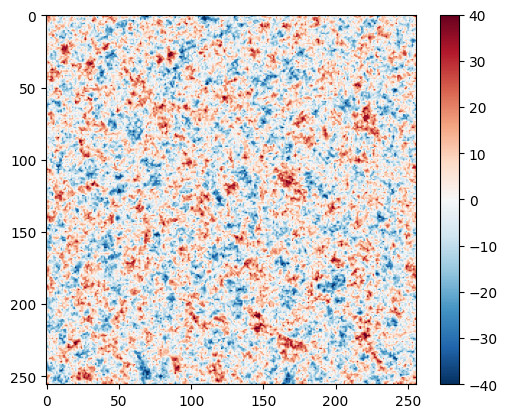

In [ ]:
plt.imshow(qi, cmap='RdBu_r',vmax=40,vmin=-40)
plt.colorbar()

In [ ]:
# # Euler, Constant StepSize
#solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

solver = dfx.Tsit5()
#stepsize_controller = dfx.PIDController(rtol=1e-4, atol=1e-4)

In [ ]:
dt=0.001

In [ ]:
t0, t1 = 0.0, dt*100
t_save = np.linspace(t0, t1, 10)
saveat = dfx.SaveAt(ts=t_save)

In [ ]:
%%time

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=State(q=SpectralField(jnp.asarray(qi), xy_domain)),
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
    max_steps=6_000
)

CPU times: user 506 ms, sys: 2.99 ms, total: 509 ms
Wall time: 509 ms


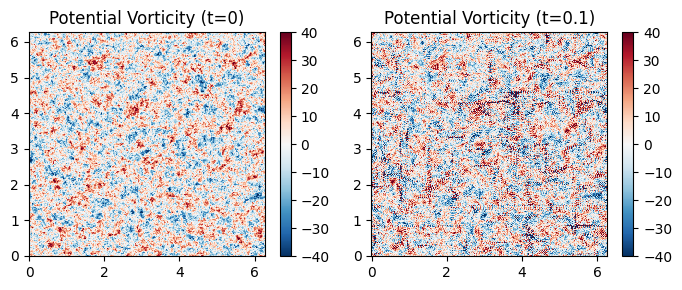

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis
q_plot = sol.ys.q[-1]


pts = ax[0].pcolormesh(X, Y, qi[:], cmap="RdBu_r",vmax=40,vmin=-40)
ax[0].set(title="Potential Vorticity (t=0)")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, q_plot[:], cmap="RdBu_r",vmax=40,vmin=-40)
ax[1].set(title=f"Potential Vorticity (t={t1})")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
# q = SpectralField(q, xy_domain)
psi = F_spectral.elliptical_inversion_2D(SpectralField(sol.ys.q[-1], xy_domain))
u = - F_spectral.difference_field(psi, axis=1, derivative=1, real=True)
v = F_spectral.difference_field(psi, axis=0, derivative=1, real=True)

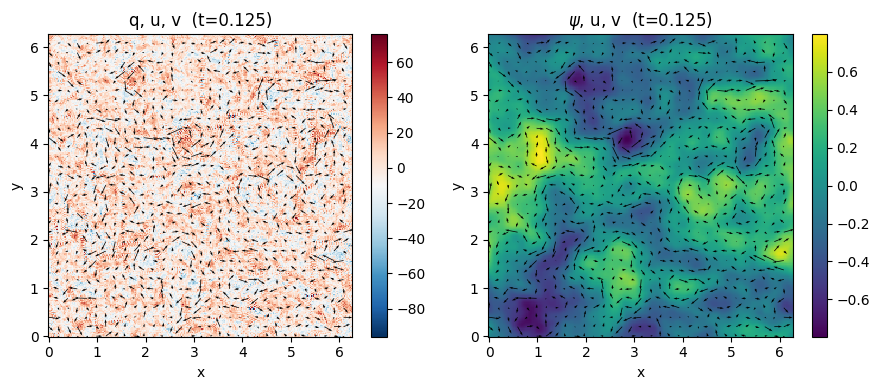

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

nc = int(Nx/32)

X, Y = sol.ys.q.domain.grid_axis
# q_plot = sol.ys.q[-2]

pts = ax[0].pcolormesh(X, Y, sol.ys.q[-1][:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title=f"q, u, v  (t={t1})")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title=f"$\psi$, u, v  (t={t1})")

plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [ ]:
def equation_of_motion(qh: Array, nu: float) -> Array:

    # calculate psi
    psih = - invksq * qh

    # calculate velocities
    u = jnp.real(jnp.fft.ifftn(- 1j * L * psih))
    v = jnp.real(jnp.fft.ifftn(1j * K * psih))
    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = jnp.real(jnp.fft.ifftn(1j * K * qh))
    dqh_dy = jnp.real(jnp.fft.ifftn(1j * L * qh))

    adv_rhs = - jnp.fft.fftn(u*dqh_dx + v*dqh_dy)

    # calculate diffusion term
    diff_rhs = - nu * ksq**2 * qh


    return adv_rhs + diff_rhs


In [ ]:
nu=3.125e-08

dt = 0.001
t1 = 100*dt
num_steps = int(t1/dt)

ts = jnp.arange(0, t1, dt)

In [ ]:
qh0 = jnp.asarray(np.fft.fftn(qi))
qh = jnp.copy(qh0)

fn = jax.jit(equation_of_motion, static_argnames="nu")

for i in tqdm(ts):

    rhs = fn(qh, nu)

    qh = qh + dt*rhs

  0%|          | 0/100 [00:00<?, ?it/s]

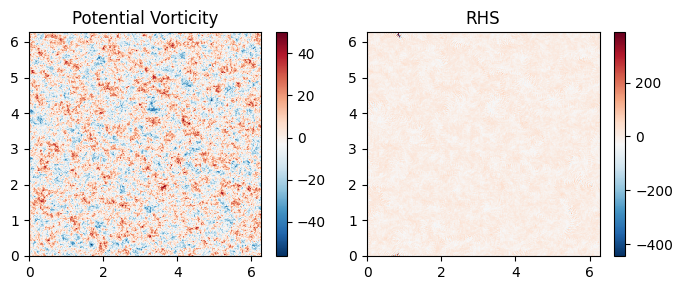

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh0)), cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh)), cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()